**[은행의 고객 이탈률]**
은행 관리자가 더 많은 고객이 현재 신용 카드 서비스를 떠나고 있다는 경고를 받고 고객을 유지하기 위한 사전 조치를 취할 수 있도록 이탈할 사람을 예측하려고 한다고 가정

이 데이터세트는 10,000명의 고객 으로 구성되어 있으며 18개의 특성을 가지고 있습니다 . 하지만 이 분석에서는 전처리를 더 간단하게 만들기 위해 범주형 특성을 사용하지 않고 11개의 숫자 특성의 하위 집합을 사용합니다 .

우리가 예측하려는 타겟 변수는 'Attrition_Flag'이며, 고객의 84%가 기존 고객이고 16%가 'Attrited Customer' 입니다 .



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
df=pd.read_csv('drive/MyDrive/BankChurners.csv')
df=df[df.columns[:-2]] # Drop the last two columns
df.head() # Inspect the first 5 rows

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
fig = make_subplots(rows=2, cols=1)
tr1 = go.Box(x=df['Customer_Age'], name='Age Box Plot', boxmean='sd')
tr2 = go.Histogram(x=df['Customer_Age'], name='Age Histogram')
fig.add_trace(tr1, row=1, col=1)
fig.add_trace(tr2, row=2, col=1)
fig.update_layout(height=500, width=600, title_text="Distribution of Customer Ages")
fig.show()

교육 수준과 소득 수준

In [4]:
education = pd.DataFrame(df['Education_Level'].value_counts())
labelsedu = df['Education_Level'].unique()
income = pd.DataFrame(df['Income_Category'].value_counts())
labelincome = df['Income_Category'].unique()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type' : 'domain'}]])
tr3 = go.Pie(labels=labelsedu, values=education.iloc[:, 0], name='proportion of Education Level')
tr4=go.Pie(labels=labelincome,values=income.iloc[:,0], name='Propotion Of Different Income Levels')
fig.add_trace(tr3,row=1,col=1)
fig.add_trace(tr4,row=1,col=2)
fig.update_layout(height=500, width=600, title_text="Distribution of Income and Education level")
fig.show()

**PCA** 예측 목적으로 기존 고객을 "1"로 예측하고 손실된 고객을 "0"으로 예측하도록 할당합니다.

In [5]:
x = df.iloc[:, 9:21] # assign column 9 to 21 as x variable - the features
x = StandardScaler().fit_transform(x)
df['Attrition_Flag'].replace('Existing Customer', '1', inplace=True)
df['Attrition_Flag'].replace('Attrited Customer', '0', inplace=True)
y=df['Attrition_Flag'] # assign y variable - the target

처음 2개의 주요 주성분 만 사용하여 시작한 다음 3개의 주성분과 4개의 주성분을 살펴보기

In [6]:
pca = PCA(n_components=2)
PC = pca.fit_transform(x)
principalDF = pd.DataFrame(data = PC, columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDF, df[['Attrition_Flag']]], axis = 1)
finalDf.head()

,pc1,pc2,Attrition_Flag
0,0.276048,-0.617639,1
1,-0.612402,1.430502,1
2,-0.613733,1.098632,1
3,-2.499317,1.781346,1
4,-0.560120,0.924119,1


이후 예측에서 각 기능에 얼마나 많은 가중치가 부여되는지 평가하기 위해 로딩 테이블을 구성할 수 있다. 로딩은 각 원래 기능이 각 "새 기능"(주요 구성 요소)에 얼마나 기여했는지 보여준다.

In [7]:
PCloadings = pca.components_.T * np.sqrt(pca.explained_variance_)
components = df.columns.tolist()
components = components[9:21]
loadingdf = pd.DataFrame(PCloadings, columns = ('PC1', 'PC2'))
loadingdf['variable'] = components
loadingdf

,PC1,PC2,variable
0,-0.012248,-0.084536,Months_on_book
1,-0.276207,-0.384630,Total_Relationship_Count
2,-0.030992,-0.105797,Months_Inactive_12_mon
3,-0.017396,-0.314187,Contacts_Count_12_mon
4,0.867614,-0.180299,Credit_Limit
5,-0.261374,0.402668,Total_Revolving_Bal
6,0.890865,-0.216361,Avg_Open_To_Buy
7,-0.012135,0.181603,Total_Amt_Chng_Q4_Q1
8,0.467479,0.763757,Total_Trans_Amt
9,0.359458,0.788716,Total_Trans_Ct


이제 로딩을 플롯 하고 주성분 1과 2 모두에서 가중치가 높은 것이 무엇인지 확인할 수 있다.

In [8]:
fig = ex.scatter(x = loadingdf['PC1'], y = loadingdf['PC2'], text = loadingdf['variable'])
fig.update_layout(
height=600,width=500,
title_text='loadings plot')
fig.update_traces(textposition='bottom center')
fig.add_shape(type="line",
x0=-0, y0=-0.5,x1=-0,y1=2.5,
line=dict(color="RoyalBlue",width=3)
)
fig.add_shape(type="line",
x0=-1, y0=0,x1=1,y1=0,
line=dict(color="RoyalBlue",width=3)
)
fig.show()

-> 총 거래 수와 총 거래 금액이 가중치가 높은 두 가지 특성

이는 두 가지 특성이 다음 예측 단계(로지스틱 회귀 사용)에서 큰 역할을 한다는 것을 의미한다. 예측의 정확도가 상당히 높다면 이 두 가지 특징이 실제로 고객 이탈을 결정하는 두 가지 중요한 요소라고 추론할 수 있다. 그러나 예측에 들어가기 전에 차원 축소를 통해 데이터를 2차원으로 시각화 할 수 있으므로 주성분에 대한 산점도를 만들어 데이터가 어떻게 분포되어 있는지 확인할 수 있다.

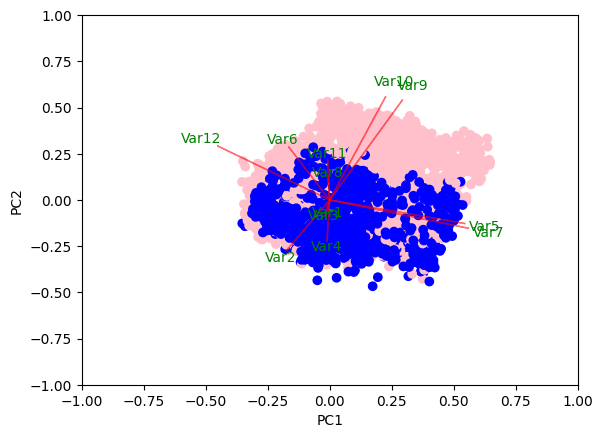

In [9]:
def myplot(score, coeff, labels=None):
  xs = score[:,0]
  ys = score[:,1]
  n = coeff.shape[0]
  scalex = 1.0/(xs.max() - xs.min())
  scaley = 1.0/(ys.max() - ys.min())
  colors = {'1':'pink', '0':'blue'}
  plt.scatter(xs*scalex, ys*scaley, c=y.apply(lambda x:colors[x]))
  for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r', alpha = 0.5)
    if labels is None:
      plt.text(coeff[i,0] * 1.15, coeff[i,1]*1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
    else:
      plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.xlabel("PC{}".format(1))
  plt.ylabel("PC{}".format(2))

myplot(PC[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Xfinal = finalDf[['pc1', 'pc2']]
yfinal = finalDf['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal, yfinal, test_size=0.3)
logistic = LogisticRegression()
logistic.fit(X=X_train, y=y_train)
logistic.predict(X_test)
score_2 = logistic.score(X_test, y_test)

In [11]:
pca=PCA(n_components=3)
PC=pca.fit_transform(x)
principalDF=pd.DataFrame(data=PC,columns=['pc1','pc2','pc3'])
finalDf = pd.concat([principalDF, df[['Attrition_Flag']]], axis = 1)
Xfinal=finalDf[['pc1','pc2','pc3']]
yfinal=finalDf['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal,yfinal,test_size=0.3)
logistic=LogisticRegression()
logistic.fit(X=X_train,y=y_train)
logistic.predict(X_test)
score_3=logistic.score(X_test,y_test)

pca=PCA(n_components=4)
PC=pca.fit_transform(x)
principalDF=pd.DataFrame(data=PC,columns=['pc1','pc2','pc3','pc4'])
finalDf = pd.concat([principalDF, df[['Attrition_Flag']]], axis = 1)
Xfinal=finalDf[['pc1','pc2','pc3','pc4']]
yfinal=finalDf['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(Xfinal,yfinal,test_size=0.3)
logistic=LogisticRegression()
logistic.fit(X=X_train,y=y_train)
logistic.predict(X_test)
score_4=logistic.score(X_test,y_test)

In [12]:
scores = [score_2, score_3, score_4]

In [13]:
ex.bar(y=scores,x=('pc2','pc3','pc4'),range_y=(0.7,0.9),title='PC prediction accuracy')

3개의 주성분이 가장 높은 점수를 준 것으로 나타났으나 , 그럼에도 불구하고 2개의 주성분으로 이미 84%의 정확도를 달성하고 있어 상당히 하강한 결과이다.

따라서 총 거래 건수와 총 거래 금액은 고객 이탈을 예측하는 좋은 변수 중 하나라고 추론할 수 있다.

도전과제

In [26]:
# 데이터 불러오기
bank = pd.read_csv('drive/MyDrive/BankChurners.csv')

print(bank.columns)

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


가장 높은 정확도: 1.0 (주성분 개수: 7)


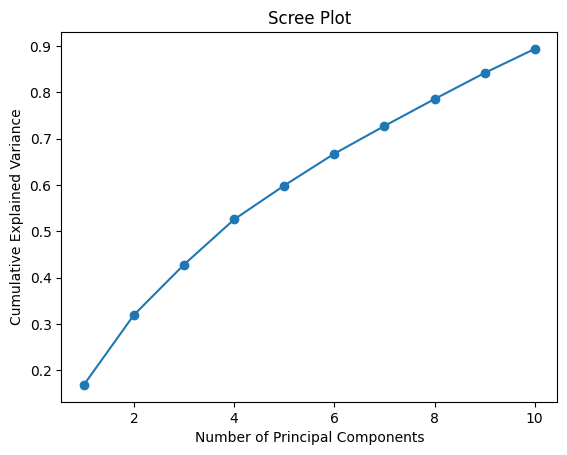

In [28]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 데이터 불러오기
bank = pd.read_csv('drive/MyDrive/BankChurners.csv')

# 'Attrition_Flag' 열이 목표 변수라고 가정하고 X, y를 나누어야 합니다.
# 이진 분류로 변환 (Attrited Customer를 1, 그 외를 0으로)
bank['Attrition_Flag'] = bank['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# 문자열을 가진 열 제거
X = bank.select_dtypes(exclude=['object']).drop('Attrition_Flag', axis=1)
y = bank['Attrition_Flag']

# 데이터 표준화 (중요: PCA를 적용하기 전에 수행해야 함)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 적용 및 성능 평가
components = range(1, 11)
explained_variances = []

# 모델 학습 및 성능 측정 코드 추가
best_accuracy = 0
best_n_components = 0

for n_components in components:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # 데이터를 학습 및 테스트 세트로 나누기
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # 머신러닝 모델 선택 (여기서는 RandomForestClassifier을 사용합니다)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # 성능 측정
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 주성분들이 설명하는 분산의 비율을 저장
    explained_variances.append(sum(pca.explained_variance_ratio_))

    # 가장 높은 정확도를 갖는 주성분 개수 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = n_components

# 결과 출력
print(f"가장 높은 정확도: {best_accuracy} (주성분 개수: {best_n_components})")

# 시각화 (Scree Plot)
plt.plot(components, explained_variances, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


이렇게 하는 게 맞는지는 잘모르겠습니다 ㅠㅠ